In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf

In [2]:
df1 = pd.read_csv('News_Final.csv')
df2 = pd.read_csv('full_data.csv')

In [3]:
df1.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,-1,-1,-1
3,27788.0,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064,-1,-1,-1
4,27789.0,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084,-1,-1,-1


In [4]:
df2.head()

,Unnamed: 0,source,author,title,description,url,requested_date,publishedAt,content
0,0,The Verge,Nick Statt,Could this be Samsung’s bezel-less 8K TV?,"Samsung may have a new, groundbreaking type of...",https://www.theverge.com/circuitbreaker/2019/1...,2019-12-31,2019-12-31T22:48:35Z,Filed under:\r\nThe company is rumored to show...
1,0,The Verge,Zoe Schiffer,TikTok claims zero takedown requests from Chin...,"TikTok, owned by Chinese tech giant ByteDance,...",https://www.theverge.com/2019/12/31/21044876/t...,2019-12-31,2019-12-31T22:39:55Z,The highest number of requests came from India...
2,0,The Verge,Zoe Schiffer,Google will finally stop using controversial I...,The company saved tens of billions of dollars ...,https://www.theverge.com/2019/12/31/21044662/g...,2019-12-31,2019-12-31T20:11:26Z,Regulations will end the Double Irish and Dutc...
3,0,The Verge,Bijan Stephen,New Apple patent imagines virtual speakers tha...,Apple has just been granted a patent — concern...,https://www.theverge.com/2019/12/31/21044677/a...,2019-12-31,2019-12-31T19:02:11Z,Apple has filed patents for the tech in both h...
4,0,The Verge,Julia Alexander,Smoke app brings parts of Valve’s Steam to the...,A new third-party app called Smoke will bring ...,https://www.theverge.com/2019/12/31/21044379/a...,2019-12-31,2019-12-31T19:00:00Z,Check in on what friends are playing\r\nFor pe...


In [5]:
len(df1['Source'].unique())

5757

In [6]:
len(df2['source'].unique())

15

In [7]:
df2['source'].unique()

array(['The Verge', 'CNN', 'The Hill', 'The New York Times',
       'The Huffington Post', 'Al Jazeera English', 'BBC News',
       'Independent', 'Reuters', 'Fox News', 'Breitbart News', 'ABC News',
       'Metro', 'Daily Mail', 'Mirror'], dtype=object)

In [8]:
news_source = ['The Verge', 'CNN', 'The Hill', 'The New York Times',
       'The Huffington Post', 'BBC News',
       'Independent', 'Reuters', 'Fox News', 'Breitbart News', 'ABC News',
       'Metro', 'Daily Mail']

In [9]:
df2 = df2.rename({'source': 'Source', 'title':'Title'}, axis=1)
df1['Source'].replace({'New York Times': 'The New York Times', 'Huffington Post': 'The Huffington Post','The Independent': 'Independent' }, inplace=True)

In [10]:
df1 = df1[df1['Source'].isin(news_source)]
df1.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
14,27814.0,"HoloLens dev edition costs £2,000 with new Con...",Microsoft’s AR headset is being made available...,Metro,microsoft,2015-03-01 02:18:00,0.000000,0.079434,-1,-1,-1
26,80801.0,"Obama Encouraging Young People to Learn Math, ...",President Barack Obama is launching a version of,The New York Times,obama,2015-03-01 04:18:00,0.044194,-0.088388,-1,-1,-1
83,27974.0,"First Hololens kit to cost $3,000",Microsoft starts taking orders for the develop...,BBC News,microsoft,2015-03-01 09:53:00,0.097828,0.167038,-1,-1,-1
98,28014.0,Microsoft begins taking preorders from develop...,Microsoft has opened up preorder sales for its...,Daily Mail,microsoft,2015-03-01 12:18:00,0.208333,-0.095312,-1,-1,-1
142,69866.0,The First-Ever Raising of Palestine's Flag at ...,"Tomorrow, the Palestinian flag will be raised ...",The Huffington Post,palestine,2015-09-29 00:00:00,0.081857,0.194754,-1,-1,-1


In [11]:
df1.reset_index(inplace=True)

In [12]:
df1_new = df1[['Title', 'Source']]
df1_new.head()

,Title,Source
0,"HoloLens dev edition costs £2,000 with new Con...",Metro
1,"Obama Encouraging Young People to Learn Math, ...",The New York Times
2,"First Hololens kit to cost $3,000",BBC News
3,Microsoft begins taking preorders from develop...,Daily Mail
4,The First-Ever Raising of Palestine's Flag at ...,The Huffington Post


In [13]:
df2_new = df2[['Title', 'Source']]
df2_new.tail()

,Title,Source
675,Left Slams Trump for Protecting Americans and ...,Breitbart News
676,Ben Rhodes:Trump Foreign Policy 'Based on Obam...,Breitbart News
677,Biden Claims Trump Less Popular than Xi Jinpin...,Breitbart News
678,Top Ten #RedforEd Political Power Plays in 201...,Breitbart News
679,"New York City teen arrested for killing, robbi...",ABC News


In [14]:
df = pd.concat([df1_new, df2_new], ignore_index=True)
df.tail()

,Title,Source
8800,Left Slams Trump for Protecting Americans and ...,Breitbart News
8801,Ben Rhodes:Trump Foreign Policy 'Based on Obam...,Breitbart News
8802,Biden Claims Trump Less Popular than Xi Jinpin...,Breitbart News
8803,Top Ten #RedforEd Political Power Plays in 201...,Breitbart News
8804,"New York City teen arrested for killing, robbi...",ABC News


In [15]:
right_media = [ 'The Hill', 'Fox News', 'Breitbart News', 'Metro', 'Daily Mail']

In [16]:
df['is_right'] = df['Source'].isin(right_media).astype(int)
df['Title'] = df['Title'].apply(str.lower)

In [17]:
df.head()

,Title,Source,is_right
0,"hololens dev edition costs £2,000 with new con...",Metro,1
1,"obama encouraging young people to learn math, ...",The New York Times,0
2,"first hololens kit to cost $3,000",BBC News,0
3,microsoft begins taking preorders from develop...,Daily Mail,1
4,the first-ever raising of palestine's flag at ...,The Huffington Post,0


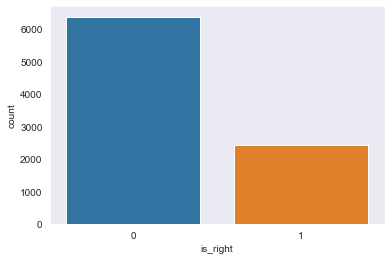

In [18]:
sns.set_style("dark")
sns.countplot(df.is_right)

In [19]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

### WORDCLOUD for Text from Right Media

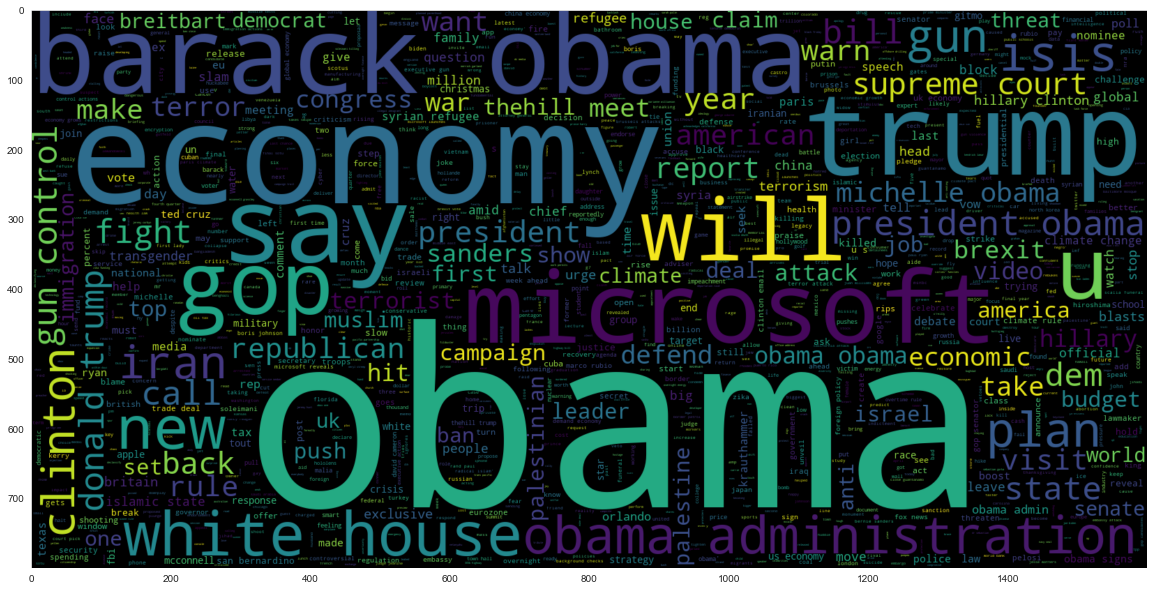

In [20]:
# Wordcloud for text from right media (label 1)
plt.figure(figsize = (20,20)) # Text that is non Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_right == 1].Title))
plt.imshow(wc , interpolation = 'bilinear')

### WORDCLOUD for Text from Left/Center Media

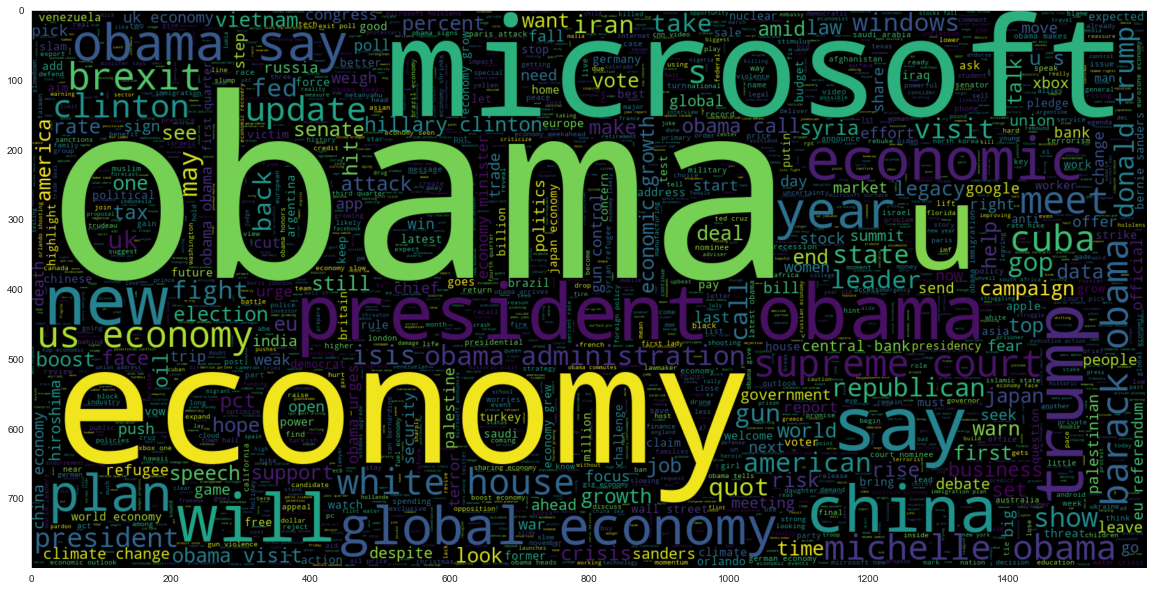

In [21]:
# Wordcloud for text from left/center media (label 0)
plt.figure(figsize = (20,20)) # Text that is non Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_right == 0].Title))
plt.imshow(wc , interpolation = 'bilinear')

### Number of Characters in Text

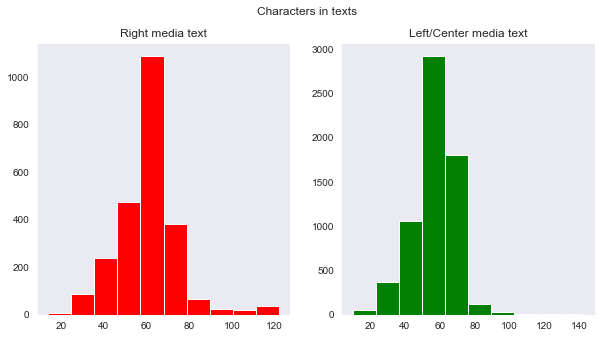

In [22]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_right']==1]['Title'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Right media text')
text_len=df[df['is_right']==0]['Title'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Left/Center media text')
fig.suptitle('Characters in texts')
plt.show()

### Number of words in each text

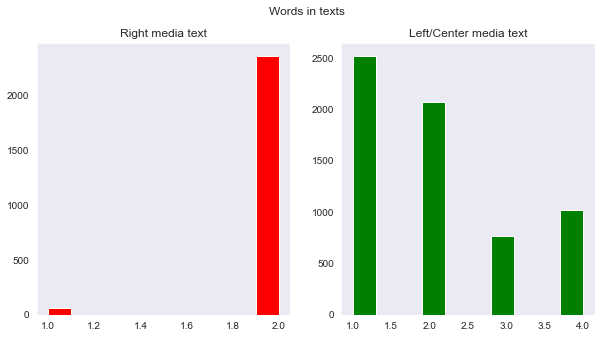

In [23]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_right']==1]['Source'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Right media text')
text_len=df[df['is_right']==0]['Source'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Left/Center media text')
fig.suptitle('Words in texts')
plt.show()

### Average word length in a text

Text(0.5, 0.98, 'Average word length in each text')

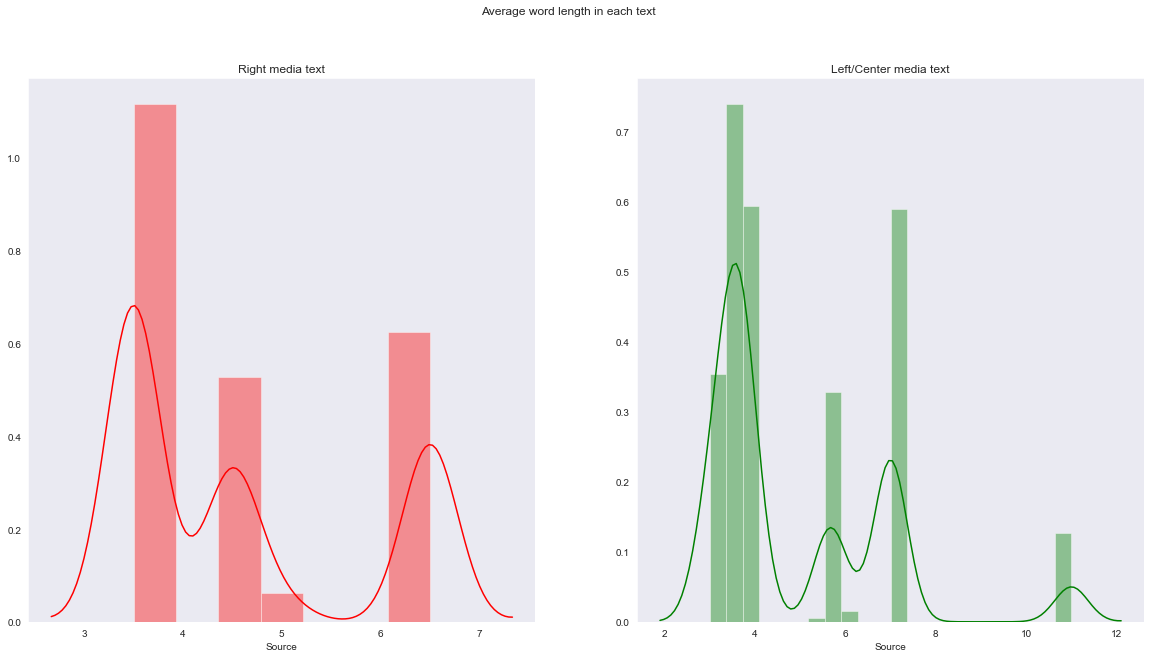

In [24]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['is_right']==1]['Source'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Right media text')
word=df[df['is_right']==0]['Source'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Left/Center media text')
fig.suptitle('Average word length in each text')

### Converting text to format acceptable by gensim

In [25]:
words = []
for i in df['Title'].values:
    words.append(i.split())
words[:5]

[['hololens',
  'dev',
  'edition',
  'costs',
  '£2,000',
  'with',
  'new',
  'conker',
  'game'],
 ['obama',
  'encouraging',
  'young',
  'people',
  'to',
  'learn',
  'math,',
  'science'],
 ['first', 'hololens', 'kit', 'to', 'cost', '$3,000'],
 ['microsoft',
  'begins',
  'taking',
  'preorders',
  'from',
  'developers',
  'for',
  'the',
  'hololens'],
 ['the',
  'first-ever',
  'raising',
  'of',
  "palestine's",
  'flag',
  'at',
  'the',
  'un',
  'is',
  'our',
  'moment',
  '...']]

In [26]:
import gensim

#Dimension of vectors we are generating
EMBEDDING_DIM = 100
#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences = words , window = 5 , min_count = 1)

In [27]:
#vocab size
#len(w2v_model.wv.vocab)
len(list(w2v_model.wv.index_to_key))
#We have now represented each of 13535 words by a ndim vector.


13535

In [28]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = 20)

In [29]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [30]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

In [31]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

## TRAINING WORD2VEC MODEL

In [32]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=20, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

/Users/Kazage/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           1353600   
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 256)           234496    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                55680     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,643,841
Trainable params: 1,643,841
Non-trainable params: 0
_________________________________________________________________


In [34]:
x_train, x_test, y_train, y_test = train_test_split(x, df.is_right , test_size = 0.3 , random_state = 0) 

In [35]:
history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 3)

Epoch 1/3
49/49 [==============================] - 27s 326ms/step - loss: 0.6052 - acc: 0.7177 - val_loss: 0.5959 - val_acc: 0.7233
Epoch 2/3
49/49 [==============================] - 15s 302ms/step - loss: 0.4232 - acc: 0.8118 - val_loss: 0.5819 - val_acc: 0.7483
Epoch 3/3
49/49 [==============================] - 15s 307ms/step - loss: 0.1782 - acc: 0.9364 - val_loss: 0.7270 - val_acc: 0.7233


In [36]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

193/193 [==============================] - 4s 19ms/step - loss: 0.0946 - acc: 0.9692
Accuracy of the model on Training Data is -  96.9170868396759
83/83 [==============================] - 2s 19ms/step - loss: 0.7270 - acc: 0.7233
Accuracy of the model on Testing Data is -  72.33156561851501


So far the model accuracy is 72.3%

## ANALYSIS AFTER TRAINING OF WORD2VEC MODEL

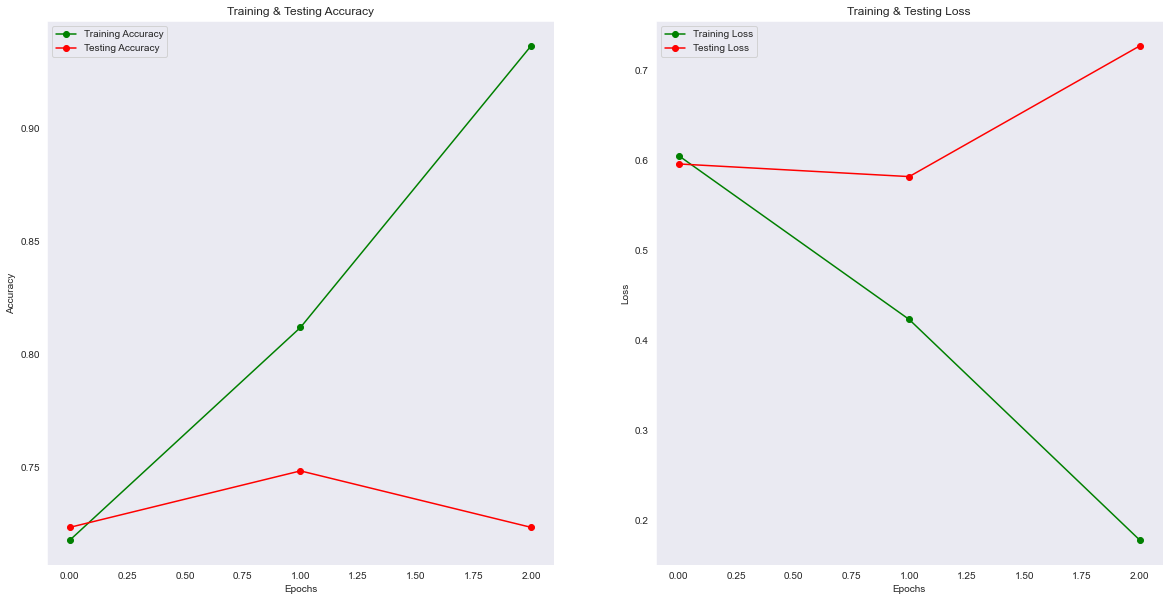

In [37]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

### SEEMS LIKE THE MODEL IS NOT PERFORMING WELL ON THE TEST DATA

In [38]:
y_pred = model.predict(x_test)
y_pred = np.round(y_pred).astype("int32")
y_pred[:5]

array([[0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

In [39]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[1657,  247],
       [ 484,  254]])

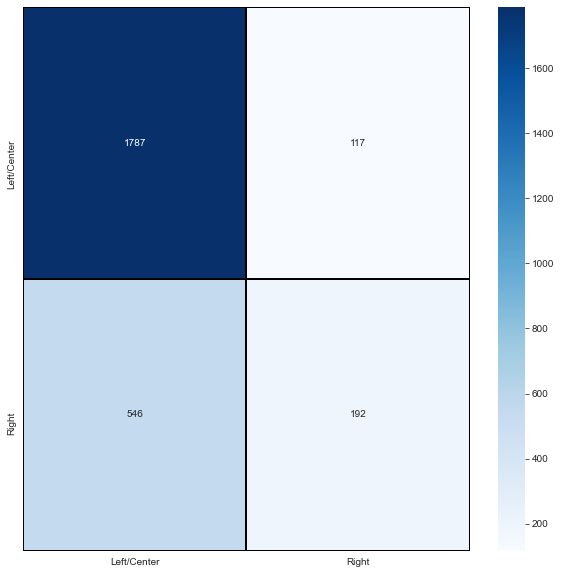

In [58]:
cm = pd.DataFrame(cm , index = ['Left/Center','Right'] , columns = ['Left/Center','Right'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Left/Center','Right'] , yticklabels = ['Left/Center','Right'])


## GLOVE

In [41]:
x_train,x_test,y_train,y_test = train_test_split(df.Title, df.is_right, test_size = 0.3 , random_state = 0)

In [42]:
max_features = 35000
maxlen = 200

In [43]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [44]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [45]:
EMBEDDING_FILE = 'glove.twitter.27B.200d.txt'

In [46]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [47]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index)) + 1
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/Users/Kazage/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


### BASIC MODEL PARAMETERS

In [48]:
batch_size = 128
epochs = 2
embed_size = 200

## TRAINING GLOVE EMBEDDINGS MODEL

In [49]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(nb_words, output_dim=embed_size, weights=[embedding_matrix], input_length=200, trainable=True))
#model.add(Embedding(input_dim = vocab_size+1, output_dim=embed_size, weights=[embedding_matrix], input_length=200, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.5 , dropout = 0.5)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 200)          1870200   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               336896    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 2,207,353
Trainable params: 2,207,353
Non-trainable params: 0
_________________________________________________________________


In [51]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = 2)

Epoch 1/2
49/49 [==============================] - 150s 3s/step - loss: 0.5996 - acc: 0.7230 - val_loss: 0.5505 - val_acc: 0.7214
Epoch 2/2
49/49 [==============================] - 130s 3s/step - loss: 0.4469 - acc: 0.7973 - val_loss: 0.5558 - val_acc: 0.7491


In [52]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

83/83 [==============================] - 11s 131ms/step - loss: 0.5558 - acc: 0.7491
Accuracy of the model on Testing Data is -  74.90537762641907


The model accuracy improved from 72.3% to 74.9%

### ANALYSIS AFTER TRAINING OF GLOVE EMBEDDINGS MODEL

In [53]:
pred = model.predict(X_test)
pred = np.round(pred).astype("int32")
pred[:5]

array([[0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

In [55]:
print(classification_report(y_test, pred, target_names = ['Left/Center','Right']))

              precision    recall  f1-score   support

 Left/Center       0.77      0.94      0.84      1904
       Right       0.62      0.26      0.37       738

    accuracy                           0.75      2642
   macro avg       0.69      0.60      0.61      2642
weighted avg       0.73      0.75      0.71      2642



In [56]:
cm = confusion_matrix(y_test,pred)
cm

array([[1787,  117],
       [ 546,  192]])

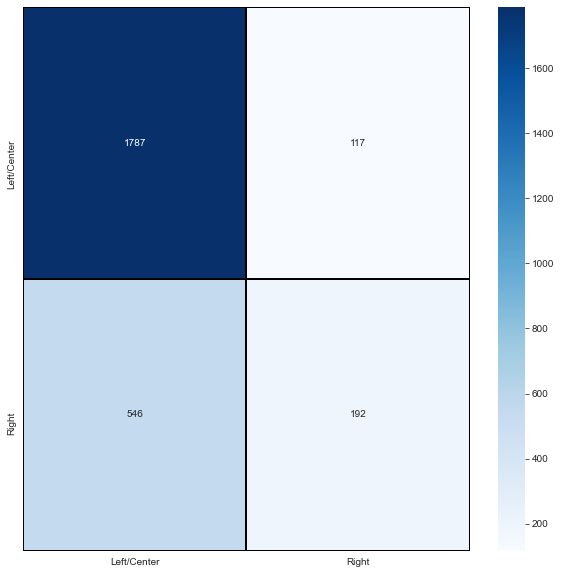

In [57]:
cm = pd.DataFrame(cm , index = ['Left/Center','Right'] , columns = ['Left/Center','Right'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Left/Center','Right'] , yticklabels = ['Left/Center','Right'])